# clEsperanto
[clEsperanto](http://clesperanto.net) ist ein Projekt zwischen mehreren Ökosystemen zur Biobildanalyse, das darauf abzielt, Sprachbarrieren zu beseitigen. Es basiert auf [OpenCL](https://www.khronos.org/opencl/), einem offenen Standard für die Programmierung von Grafikprozessoren (GPUs und mehr) und seinem Python-Wrapper [pyopencl](https://documen.tician.de/pyopencl/). Unter der Haube verwendet es Verarbeitungskernels, die aus dem [clij](https://clij.github.io) Projekt stammen.

Siehe auch
* [GPU-beschleunigte Bildanalyse in Fiji und Napari, EuroBioimaging Virtual Pub](https://www.youtube.com/watch?v=MERVnf5_QkI)
* [pyclesperanto-prototype](https://github.com/clEsperanto/pyclesperanto_prototype)
* [pyclesperanto API](https://clij.github.io/clij2-docs/reference__pyclesperanto)
* [Napari pyclesperanto Assistant](https://clesperanto.github.io/napari_pyclesperanto_assistant/)

## GPU-Initialisierung
Wir beginnen damit, zu überprüfen, welche GPUs installiert sind:

In [1]:
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import stackview

# list available devices
cle.available_device_names()

['NVIDIA GeForce RTX 3050 Ti Laptop GPU',
 'gfx1035',
 'cupy backend (experimental)']

In [2]:
# select a specific device with only a part of its name
cle.select_device("2080")

C:\Users\haase\mambaforge\envs\bio39\lib\site-packages\pyclesperanto_prototype\_tier0\_device.py:77: UserWarning: No OpenCL device found with 2080 in their name. Using gfx1035 instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


<gfx1035 on Platform: AMD Accelerated Parallel Processing (2 refs)>

In [3]:
# check which device is uses right now
cle.get_device()

<gfx1035 on Platform: AMD Accelerated Parallel Processing (2 refs)>

## Verarbeitung von Bildern
Zum Laden von Bilddaten verwenden wir wie üblich scikit-image:

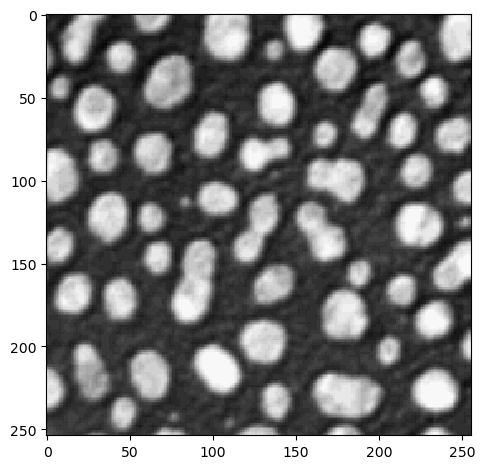

In [4]:
from skimage.io import imread, imshow

image = imread("../../data/blobs.tif")
imshow(image)

Das `cle.` Gateway enthält alle Methoden, die Sie benötigen, es hat keine Unterpakete:

cl.OCLArray([[ 41.428753,  34.696438,  27.733936, ..., 220.92714 , 211.21164 ,
        206.71573 ],
       [ 47.421425,  38.878723,  30.323011, ..., 228.32323 , 220.60194 ,
        216.83534 ],
       [ 48.121437,  40.610855,  33.357384, ..., 235.32935 , 229.7049  ,
        226.88821 ],
       ...,
       [ 74.4386  ,  76.32904 ,  77.03725 , ...,  48.000324,  48.00075 ,
         48.001007],
       [ 81.793655,  81.17787 ,  79.80763 , ...,  48.      ,  48.      ,
         48.      ],
       [ 88.816925,  85.382095,  81.478806, ...,  48.      ,  48.      ,
         48.      ]], dtype=float32)
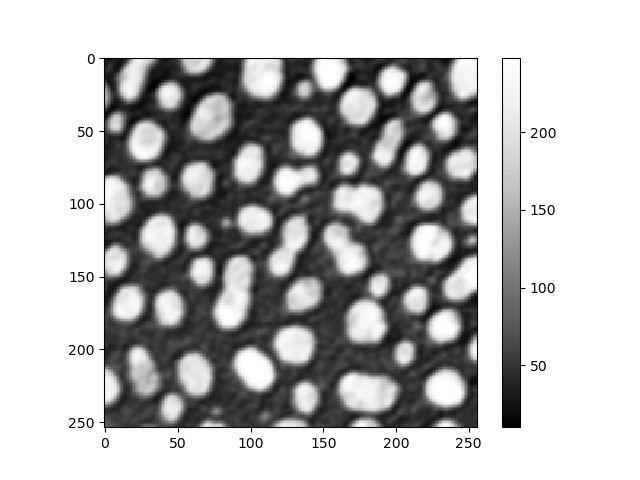
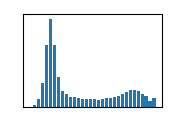

In [5]:
# noise removal
blurred = cle.gaussian_blur(image, sigma_x=1, sigma_y=1)
blurred

cl.OCLArray([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
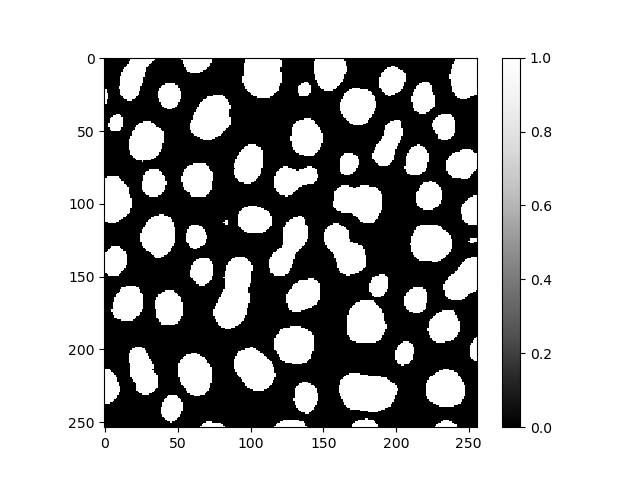
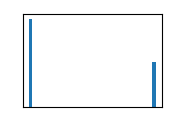

In [6]:
# binarization
binary = cle.threshold_otsu(blurred)
binary

cl.OCLArray([[ 0,  0,  0, ..., 59, 59, 59],
       [ 0,  0,  0, ..., 59, 59, 59],
       [ 0,  0,  0, ..., 59, 59, 59],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
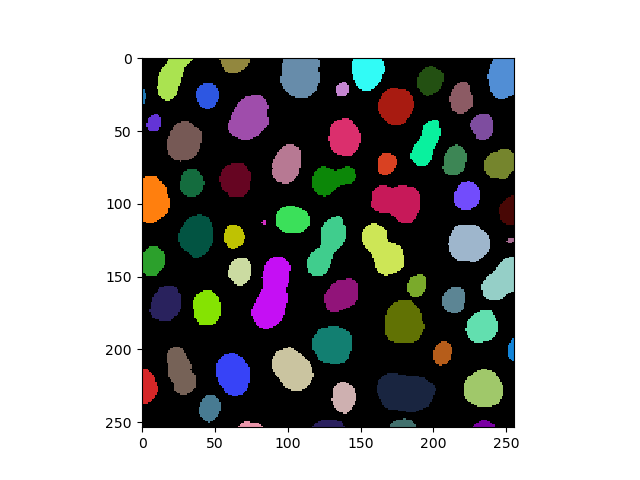

In [7]:
# labeling
labels = cle.connected_components_labeling_box(binary)
labels

C:\Users\haase\mambaforge\envs\bio39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


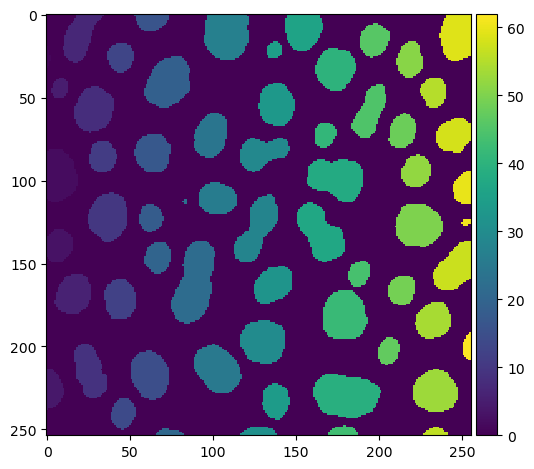

In [8]:
# visualize results
imshow(labels)

`stackview` bietet auch eine imshow-Funktion, die es beispielsweise ermöglicht, Labelbilder bequemer anzuzeigen:

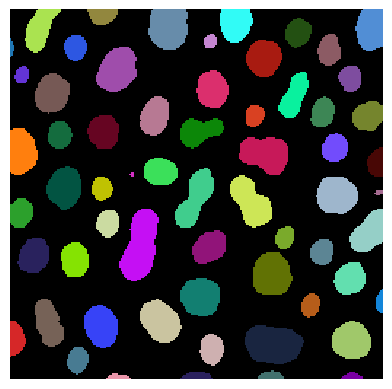

In [9]:
stackview.imshow(labels)

Man kann auch Labelkanten bestimmen und sie über das Bild blenden.

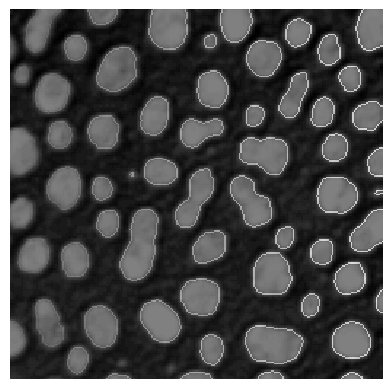

In [10]:
label_edges = cle.detect_label_edges(labels) * labels

stackview.imshow(image, continue_drawing=True)
stackview.imshow(label_edges, alpha=0.5)

Daher kann es sinnvoll sein, die Abbildung zu vergrößern und mehrere Unterplots zu kombinieren

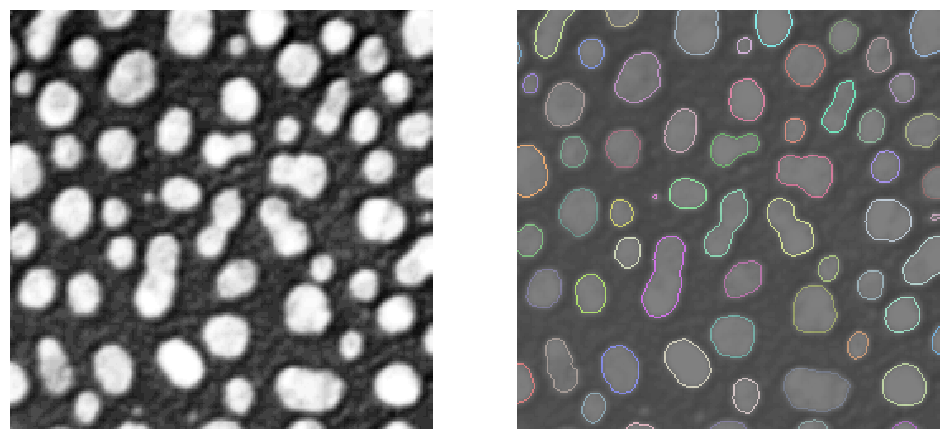

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12,12))

# left plot
stackview.imshow(image, plot=axs[0])

# right plot
stackview.imshow(image, alpha=0.5, continue_drawing=True, plot=axs[1])
stackview.imshow(label_edges, labels=True, alpha=0.5, plot=axs[1])

Einige dieser Operationen, z.B. [voronoi_otsu_labeling](https://nbviewer.jupyter.org/github/clEsperanto/pyclesperanto_prototype/blob/master/demo/segmentation/voronoi_otsu_labeling.ipynb) sind in der Tat Abkürzungen und kombinieren eine Reihe von Operationen wie Gaußsche Unschärfe, Voronoi-Labeling und Otsu-Schwellenwertbildung, um direkt von einem Rohbild zu einem Labelbild zu gelangen:

cl.OCLArray([[ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
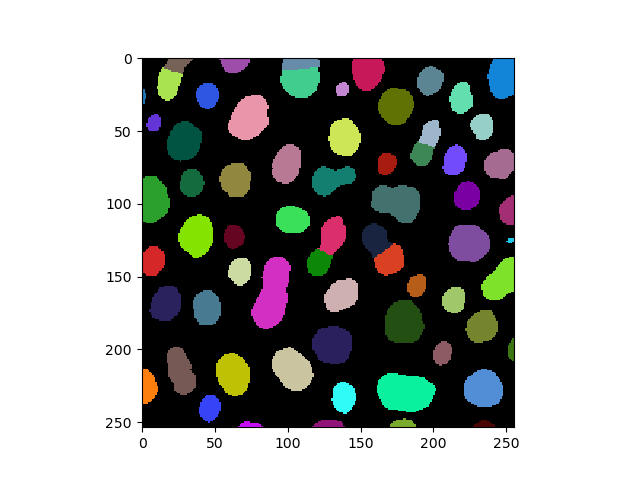

In [12]:
labels = cle.voronoi_otsu_labeling(image, spot_sigma=3.5, outline_sigma=1)
labels

Auch eine Erinnerung: Lesen Sie die Dokumentation von Methoden, die Sie noch nicht verwendet haben:

In [13]:
print(cle.voronoi_otsu_labeling.__doc__)

Labels objects directly from grey-value images.

    The two sigma parameters allow tuning the segmentation result. Under the hood,
    this filter applies two Gaussian blurs, spot detection, Otsu-thresholding [2] and Voronoi-labeling [3]. The
    thresholded binary image is flooded using the Voronoi tesselation approach starting from the found local maxima.

    Notes
    -----
    * This operation assumes input images are isotropic.

    Parameters
    ----------
    source : Image
        Input grey-value image
    label_image_destination : Image, optional
        Output image
    spot_sigma : float, optional
        controls how close detected cells can be
    outline_sigma : float, optional
        controls how precise segmented objects are outlined.
    
    Returns
    -------
    label_image_destination
    
    Examples
    --------
    >>> import pyclesperanto_prototype as cle
    >>> cle.voronoi_otsu_labeling(source, label_image_destination, 10, 2)
    
    References
    --

## Interoperabilität 
In pyclesperanto werden Bilder im Arbeitsspeicher (RAM) Ihrer GPU verarbeitet. Wenn Sie andere Bibliotheken verwenden möchten, die Bilder auf der GPU verarbeiten, muss der Speicher zurück übertragen werden. Normalerweise geschieht dies für den Benutzer transparent, z.B. bei der Verwendung von scikit-image zur Messung von Regioneneigenschaften:

In [14]:
from skimage.measure import regionprops

statistics = regionprops(labels)

import numpy as np
np.mean([s.area for s in statistics])

333.77272727272725

Wenn Sie Ihr Bild explizit konvertieren möchten, z.B. in ein numpy-Array, können Sie das so machen:

In [15]:
np.asarray(labels)

array([[ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)

## Speicherverwaltung
In Jupyter-Notebooks bleiben Variablen so lange am Leben, wie der Notebook-Kernel läuft. Dadurch kann sich Ihre GPU mit Speicher füllen. Wenn Sie also ein Bild nicht mehr benötigen, entfernen Sie es mit `del` aus dem Speicher. Es wird dann dank der [pyopencl](https://documen.tician.de/pyopencl/)-Magie aus dem GPU-Speicher entfernt.

In [16]:
del image
del blurred
del binary
del labels